# **PROBLEM STATEMENT**

Concern about delays in credit card payments on FinanKu which will harm business.
So that people who have the potential to experience late payments can be predicted more quickly to determine appropriate strategies for dealing with future conditions.

# **OBJECTIVE**

Create a model that can predict at least 60% of customers who will experience late credit card payments [Accuracy & Recall above 60%]

# **AVAILABLE VARIABEL**

From the dataset we have, there are several data available:

---

**1. Customer ID:** Unique ID Customer\
**2. Branch:** Registered Customer Branch Location\
**3. City:** Location of Registered Customer's City\
**4. Age:** Customer Age During the Observation Period\
**5. Avg. Annual Income/Month:** Average customer income in one year\
**6. Balance (Q1-Q4):** The customer's settled balance at the end of the quarter\
**7. Num of Products (Q1-Q4):** Number of customer product holdings at the end of the quarter\
**8. HasCrCard (Q1-Q4):** Customer credit card product ownership status at the end of the quarter\
**9. Active Member (Q1-Q4):** Customer active status\
**10. Unpaid Tagging:** Customer status in default


# **EXPERIMENT**

Review Period:
1. Customers are reviewed for the past year
2. Customers are reviewed for the last 6 months

Variable Adjustment:
1. Balance is seen as an average over a time horizon & changes are seen at the end of the review and the beginning of the review
2. View the average, maximum, and minimum product count holdings in the review period
3. Customer activity status is seen in the form of months

# Import Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
#from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer,accuracy_score,precision_score,recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
#from jcopml.feature_importance import mean_score_decrease

In [2]:
# display setting
pd.set_option('display.max_columns', None)

# Data For Prediction

In [3]:
# Read and main Dataset
path_1 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20All.csv"
path_2 = "https://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20Validasi.csv"
df_all = pd.read_csv(path_1)
df_val = pd.read_csv(path_2)

Dataset for Eksperimen 1

In [4]:
df1 = pd.read_csv(path_1)
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0


Dataset for Eksperimen 2

In [5]:
df2 = pd.read_csv(path_1)
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0


# Data Understanding

Distribution of Customers Based on Location

 - Overall Distribution
 - Distribution of Defaulting Customers

In [6]:
data1 = pd.DataFrame(\
                     # Grouping by city based on the number of customers
                     df_all.groupby(by=["City"])["Customer ID"]\
                     # Aggregated by calculating the number (count)
                     .count()\
                     # sort the data
                     .sort_values(ascending=False)
                     # Reset the header name
                     .reset_index(name='Distribution by City'))
data1

,City,Distribution by City
0,Surabaya,3767
1,Bandung,1898
2,Jakarta,1896


In [7]:
data2 = pd.DataFrame(\
                     # Grouping Unpaid Tagging = 1 Based on City seen from the number of customers
                     df_all[df_all["Unpaid Tagging"]==1].groupby(by=["City"])["Customer ID"]\
                     # Aggregated by calculating the number (count)
                     .count()\
                     # Sort the data
                     .sort_values(ascending=False)\
                     # Reset the header name
                     .reset_index(name='Distribution by City'))
data2

,City,Distribution by City
0,Surabaya,1033
1,Bandung,496
2,Jakarta,490


Distribution of Customers Based on Age
- Overall Distribution
- Distribution of Defaulting Customers

<Axes: title={'center': 'Cust. Distribution by Age'}, xlabel='Age', ylabel='People'>

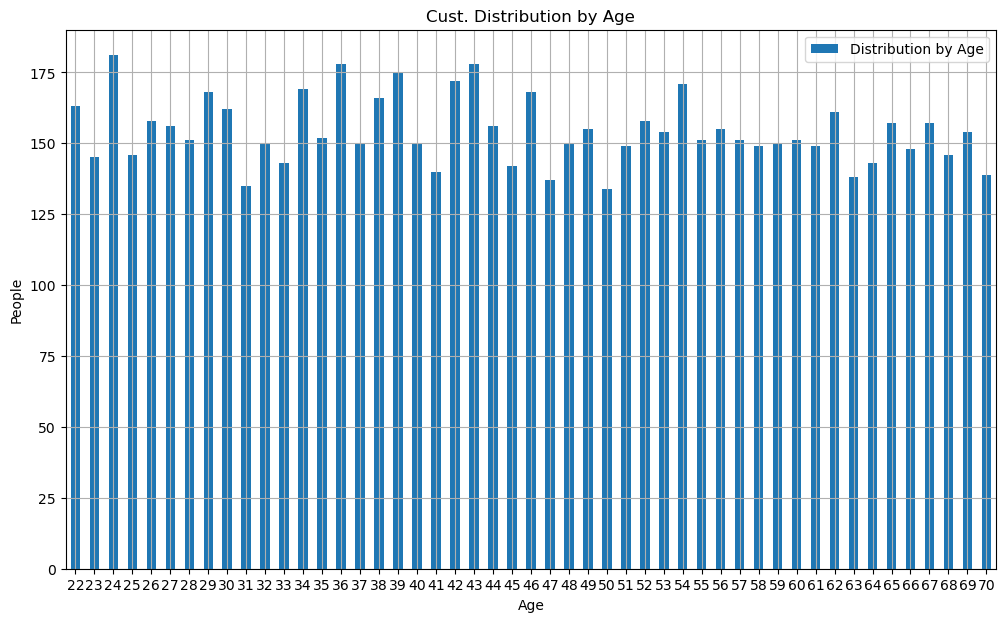

In [8]:
# view customer data as a whole

data3 = pd.DataFrame(df_all.groupby(by=["Age"])["Customer ID"].count().reset_index(name='Distribution by Age'))

data3.sort_values(by=['Age'], ascending=True,inplace=True)


data3.plot(x='Age',
           y='Distribution by Age',
           kind='bar',
           grid = True,
           xlabel = 'Age',
           ylabel = 'People',
           figsize=(12,7),
           rot = 0,
           title = 'Cust. Distribution by Age',
           table = False,
           secondary_y = False)

<Axes: title={'center': 'Unpaid Cust. Distribution by Age'}, xlabel='Age', ylabel='# People'>

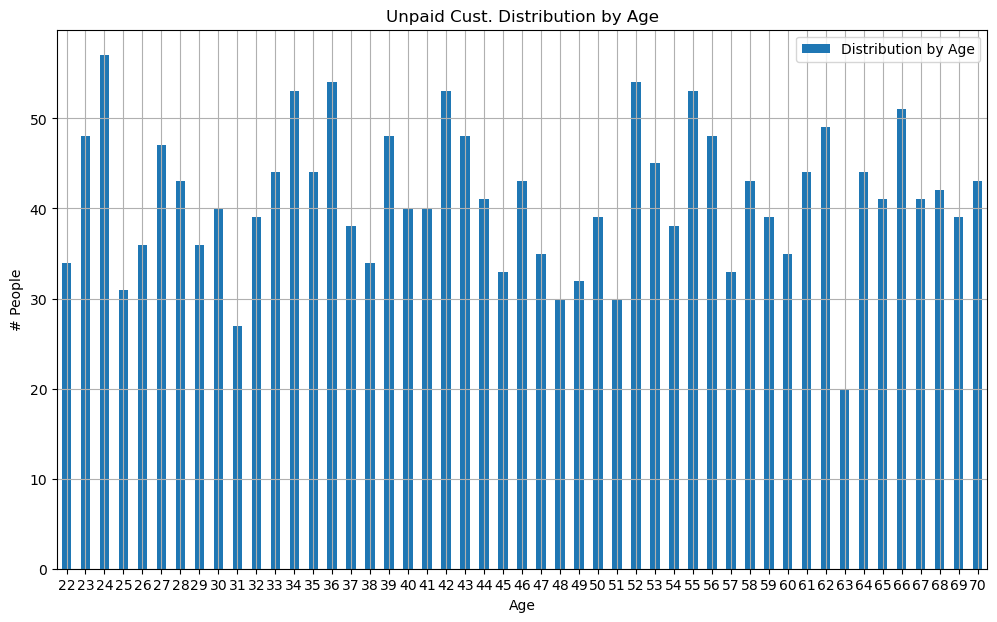

In [9]:
# view data on customers who have failed to pay

data4 = pd.DataFrame(df_all[df_all["Unpaid Tagging"]==1].groupby(by=["Age"])["Customer ID"]\
                     .count()\
                     .reset_index(name='Distribution by Age'))

data4.sort_values(\
                  by=['Age'], \
                  ascending=True,\
                  inplace=True)


data4.plot(x='Age',
           y=['Distribution by Age'],
           kind='bar',
           grid = True,
           xlabel = 'Age',
           ylabel = '# People',
           figsize=(12,7),
           rot = 0,
           title = 'Unpaid Cust. Distribution by Age',
           table = False,
           secondary_y = False)

**Average Customer Balance** (Total Balence and Avg Balance)

In [10]:
df_checkbalance = df_all

In [11]:
# calculate Total balance and Average Balance
df_checkbalance['Total Balance'] = df_checkbalance['Balance Q1']+df_checkbalance['Balance Q2']+df_checkbalance['Balance Q3']+df_checkbalance['Balance Q4']
df_checkbalance['Avg Balance'] = (df_checkbalance['Balance Q1']+df_checkbalance['Balance Q2']+df_checkbalance['Balance Q3']+df_checkbalance['Balance Q4'])/4

In [12]:
data5 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Total Balance"]\
                     .mean()\
                     .reset_index(name='Avg Annual Balance'))
data5

,Unpaid Tagging,Avg Annual Balance
0,0,1.985924e+08
1,1,2.527238e+08


In [13]:
data6 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Avg Balance"]\
                     .mean()\
                     .reset_index(name='Avg Quarterly Balance'))
data6

,Unpaid Tagging,Avg Quarterly Balance
0,0,4.964809e+07
1,1,6.318095e+07


**Average Product Ownership**

In [14]:
df_checkbalance['Avg Product'] = (df_checkbalance['NumOfProducts Q1'] + df_checkbalance['NumOfProducts Q2'] + df_checkbalance['NumOfProducts Q3'] + df_checkbalance['NumOfProducts Q4'])/4

In [15]:
# look at failure and non-default from the average product ownership
data7 = pd.DataFrame(\
                     df_checkbalance.groupby(by=["Unpaid Tagging"])["Avg Product"]\
                     .mean()\
                     .reset_index(name='Avg Product Owned'))
data7

,Unpaid Tagging,Avg Product Owned
0,0,1.667223
1,1,1.609336


In [16]:
# drop the column that has been created
df_all = df_all.drop(columns=['Total Balance', 'Avg Balance','Avg Product'])

# Data Preparation

## Duplicate Data Checking and *Missing Data*

In [17]:
df_all.duplicated().sum()

0

In [18]:
df_all.isnull().sum()

Customer ID                 0
Branch Code                 0
City                        0
Age                         0
Avg. Annual Income/Month    0
Balance Q1                  0
NumOfProducts Q1            0
HasCrCard Q1                0
ActiveMember Q1             0
Balance Q2                  0
NumOfProducts Q2            0
HasCrCard Q2                0
ActiveMember Q2             0
Balance Q3                  0
NumOfProducts Q3            0
HasCrCard Q3                0
ActiveMember Q3             0
Balance Q4                  0
NumOfProducts Q4            0
HasCrCard Q4                0
ActiveMember Q4             0
Unpaid Tagging              0
dtype: int64

## Addition of Relevant Variables (columns).

**Average Balance & Changes in Balance During the Observation Period**

View customer balances within the observation scope
1. Experiment 1: Average customer balance in the last 1 year & Changes in Balance in Q4 versus Q1
2. Experiment 2: Average customer balance in the last 6 months & Changes in Balance in Q4 to Q2

Eksperimen 1

In [19]:
df1['Mean Balance'] = (df1['Balance Q1']+df1['Balance Q2']+df1['Balance Q3']+df1['Balance Q4'])/4
df1['Delta Balance'] = df1['Balance Q4']-df1['Balance Q1']

In [20]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68


Eksperimen 2

In [21]:
df2['Mean Balance'] = (df2['Balance Q3']+df2['Balance Q4'])/2
df2['Delta Balance'] = df2['Balance Q4']-df2['Balance Q2']

In [22]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68


**Active Status**

View active customer periods within the observation scope
1. Experiment 1 --> Customer activity (in months) in the last 1 year
2. Experiment 2 --> Customer activity (in months) in the last 6 months

Eksperimen 1

In [23]:
df1['Active Months'] = (df1['ActiveMember Q1']+df1['ActiveMember Q2']+df1['ActiveMember Q3']+df1['ActiveMember Q4'])*3 # dikali 3 untuk mengkonfersi data quarterly ke monthly (4x3 = 12)

In [24]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6


Eksperimen 2

In [25]:
df2['Active Months'] = (df2['ActiveMember Q3']+df2['ActiveMember Q4'])*3 # dikali 3 untuk mengkonfersi data quarterly ke monthly (4x3 = 12)

In [26]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6


**Addition/Reduction of Product Holding**

Seeing fluctuations in customer product ownership during the observation period

Eksperimen 1

In [27]:
df1['Diff PH'] = df1['NumOfProducts Q4']-df1['NumOfProducts Q1']

In [28]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6,0


Eksperimen 2

In [29]:
df2['Diff PH'] = df2['NumOfProducts Q4']-df1['NumOfProducts Q2']

In [30]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6,0


**Length of Credit Card Ownership During the Observation Period**

In [31]:
def assign_cr1(df):
    if df['HasCrCard Q1'] == 1:
        return 12
    elif df['HasCrCard Q2'] == 1:
        return 9
    elif df['HasCrCard Q3'] == 1:
        return 6
    else:
        return 3
    return np.nan

Eksperimen 1

In [32]:
df1['Vintage_CR'] = df1.apply(assign_cr1, axis = 1)

In [33]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6,0,12


Eksperimen 2

In [34]:
df2['Vintage_CR'] = df2.apply(assign_cr1, axis = 1)

In [35]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,593518.09,1187036.18,3,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,675910.12,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.00,0.00,0,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,555048.18,431190.68,6,0,12


## Variable Deletion
delete all the quarter columns because they have been defined again before

Ownership Status Has Been Replaced With Length of Credit Card Ownership

In [36]:
df1 = df1.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])
df2 = df2.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])

Balance Per Quarter has been replaced with the average balance in the observation period & the difference in balance at the beginning and end of the observation period

In [37]:
df1 = df1.drop(columns = ['Balance Q1', 'Balance Q2', 'Balance Q3', 'Balance Q4'])
df2 = df2.drop(columns = ['Balance Q1', 'Balance Q2', 'Balance Q3', 'Balance Q4'])

Total Product Ownership has been replaced by fluctuations in product ownership during the observation period

In [38]:
df1 = df1.drop(columns = ['NumOfProducts Q1', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'])
df2 = df2.drop(columns = ['NumOfProducts Q1', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4'])

Customer Activity Status Per Quarter has been replaced with Activity Status in Months

In [39]:
df1 = df1.drop(columns = ['ActiveMember Q1', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])
df2 = df2.drop(columns = ['ActiveMember Q1', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])

## Data Transformation

Separation of Predictor Variables

---

In [40]:
# Retrieves all columns except "Customer ID" and "Unpaid Tagging"
predictor1 = df1[df1.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2 = df2[df2.columns.difference(['Customer ID', 'Unpaid Tagging'])]

In [41]:
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,6,29,33000000,1001,Jakarta,1187036.18,0,296759.045,12
1,3,68,17000000,1005,Jakarta,0.00,0,0.000,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,337955.060,12
3,3,42,19000000,1008,Jakarta,0.00,0,0.000,12
4,6,43,29000000,1009,Jakarta,431190.68,0,277524.090,12


In [42]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,3,29,33000000,1001,Jakarta,1187036.18,0,593518.09,12
1,0,68,17000000,1005,Jakarta,0.00,0,0.00,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,675910.12,12
3,0,42,19000000,1008,Jakarta,0.00,0,0.00,12
4,6,43,29000000,1009,Jakarta,431190.68,0,555048.18,12


Performing Encoding for Category Data

---
\
Variable Category:
1. Branch Code
2. City

The branch code needs to be converted into a string so that it is considered category/string data

In [43]:
predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)

C:\Users\User\AppData\Local\Temp\ipykernel_4008\1205290035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
C:\Users\User\AppData\Local\Temp\ipykernel_4008\1205290035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)


In [44]:
predictor1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


In [45]:
predictor2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Months             7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   Vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


In [46]:
# perform encoding on object/string data
predictor1 = pd.get_dummies(predictor1)
predictor2 = pd.get_dummies(predictor2)

In [47]:
predictor1.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1187036.18,0,296759.045,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,3,68,17000000,0.00,0,0.000,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,337955.060,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,3,42,19000000,0.00,0,0.000,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,277524.090,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [48]:
predictor2.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,3,29,33000000,1187036.18,0,593518.09,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.00,0,0.00,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,3,25,12000000,1351820.24,0,675910.12,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.00,0,0.00,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.68,0,555048.18,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [49]:
# Store the names of the columns in variables
predname = predictor1.columns
predname_num = predictor1.columns[0:7]
predname_cat = predictor1.columns[7:31]

In [50]:
predname

Index(['Active Months', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'Vintage_CR', 'Branch Code_1001',
       'Branch Code_1002', 'Branch Code_1003', 'Branch Code_1004',
       'Branch Code_1005', 'Branch Code_1006', 'Branch Code_1007',
       'Branch Code_1008', 'Branch Code_1009', 'Branch Code_1011',
       'Branch Code_1012', 'Branch Code_1013', 'Branch Code_1014',
       'Branch Code_1015', 'Branch Code_1021', 'Branch Code_1022',
       'Branch Code_1023', 'Branch Code_1024', 'City_Bandung', 'City_Jakarta',
       'City_Surabaya'],
      dtype='object')

In [51]:
predname_num

Index(['Active Months', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'Vintage_CR'],
      dtype='object')

In [52]:
predname_cat

Index(['Branch Code_1001', 'Branch Code_1002', 'Branch Code_1003',
       'Branch Code_1004', 'Branch Code_1005', 'Branch Code_1006',
       'Branch Code_1007', 'Branch Code_1008', 'Branch Code_1009',
       'Branch Code_1011', 'Branch Code_1012', 'Branch Code_1013',
       'Branch Code_1014', 'Branch Code_1015', 'Branch Code_1021',
       'Branch Code_1022', 'Branch Code_1023', 'Branch Code_1024',
       'City_Bandung', 'City_Jakarta', 'City_Surabaya'],
      dtype='object')

In [53]:
X1_num = predictor1[predname_num]
X2_num = predictor2[predname_num]
X1_cat = predictor1[predname_cat]
X2_cat = predictor2[predname_cat]

Standardization of Numerical Data

In [54]:
# standarisasi X1_num
from sklearn.preprocessing import StandardScaler
pt = StandardScaler()

X1_num = pd.DataFrame(pt.fit_transform(X1_num))
X1_num.head()

,0,1,2,3,4,5,6
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [55]:
# Enter the above value in the prednam_num column
X1_num.columns = predname_num
X1_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [56]:
X2_num = pd.DataFrame(pt.fit_transform(X2_num))
X2_num.head()

,0,1,2,3,4,5,6
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [57]:
X2_num.columns = predname_num
X2_num.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


## Combining Predictor Datasets

In [58]:
X1 = pd.concat([X1_cat, X1_num], axis = 1)
X2 = pd.concat([X2_cat, X2_num], axis = 1)

In [59]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [60]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [61]:
# Untuk variabel dependent
y1 = df1['Unpaid Tagging']
y2 = df2['Unpaid Tagging']

## Preparing Dataset for Validation

The process is almost the same as the previous steps, only the dataset is different

### Import Data

In [62]:
df1_val = pd.read_csv(path_2)
df2_val = pd.read_csv(path_2)

In [63]:
df1_val.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0


In [64]:
df2_val.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0


### Addition of Relevant Variables

**Average Balance & Changes in Balance**

In [65]:
df1_val['Mean Balance'] = (df1_val['Balance Q2']+df1_val['Balance Q3']+df1_val['Balance Q4']+df1_val['Balance Q5'])/4
df2_val['Mean Balance'] = (df2_val['Balance Q4']+df1_val['Balance Q5'])/2

In [66]:
df1_val['Delta Balance'] = df1_val['Balance Q5']-df1_val['Balance Q2']
df2_val['Delta Balance'] = df2_val['Balance Q5']-df2_val['Balance Q3']

### Active Status

In [67]:
df1_val['Active Months'] = (df1_val['ActiveMember Q2']+df1_val['ActiveMember Q3']+df1_val['ActiveMember Q4']+df1_val['ActiveMember Q5'])*3
df2_val['Active Months'] = (df2_val['ActiveMember Q4']+df1_val['ActiveMember Q5'])*3

### Addition/Reduction of Product Holding

In [68]:
df1_val['Diff PH'] = df1_val['NumOfProducts Q5']-df1_val['NumOfProducts Q2']
df2_val['Diff PH'] = df2_val['NumOfProducts Q5']-df1_val['NumOfProducts Q3']

### Length of Credit Card Ownership

In [69]:
def assign_cr2(df):
    if df['HasCrCard Q2'] == 1:
        return 12
    elif df['HasCrCard Q3'] == 1:
        return 9
    elif df['HasCrCard Q4'] == 1:
        return 6
    else:
        return 3
    return np.nan

In [70]:
df1_val['Vintage_CR'] = df1_val.apply(assign_cr2, axis = 1)
df2_val['Vintage_CR'] = df2_val.apply(assign_cr2, axis = 1)

### Variable Deletion

In [71]:
df1_val = df1_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4','Balance Q5', 'Balance Q2', 'Balance Q3', 'Balance Q4','NumOfProducts Q5', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4','ActiveMember Q5', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])
df2_val = df2_val.drop(columns = ['HasCrCard Q5', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4','Balance Q5', 'Balance Q2', 'Balance Q3', 'Balance Q4','NumOfProducts Q5', 'NumOfProducts Q2', 'NumOfProducts Q3', 'NumOfProducts Q4','ActiveMember Q5', 'ActiveMember Q2', 'ActiveMember Q3', 'ActiveMember Q4'])

In [72]:
df1_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,6.231940e+05,1.305740e+06,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0,7.435011e+05,1.622184e+06,6,0,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0,2,12
4,15566312,1009,Jakarta,43,29000000,0,3.853218e+05,4.311907e+05,6,1,12
5,15566495,1005,Jakarta,27,15000000,0,5.647607e+07,1.365946e+07,9,0,12
6,15566543,1003,Jakarta,68,26000000,0,1.234332e+08,5.441502e+07,9,2,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0,0,12
8,15566689,1003,Jakarta,43,38000000,0,2.247047e+05,2.996062e+05,3,1,12
9,15566958,1005,Jakarta,70,23000000,0,8.243379e+07,1.169147e+07,9,0,6


In [73]:
df2_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Months,Diff PH,Vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,1.246388e+06,1.305740e+06,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0,1.487002e+06,1.622184e+06,6,0,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0,2,12
4,15566312,1009,Jakarta,43,29000000,0,4.311907e+05,-2.477150e+05,3,1,12
5,15566495,1005,Jakarta,27,15000000,0,5.990946e+07,1.338732e+07,6,0,12
6,15566543,1003,Jakarta,68,26000000,0,1.370369e+08,5.481477e+07,3,1,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0,0,12
8,15566689,1003,Jakarta,43,38000000,0,2.996062e+05,0.000000e+00,0,1,12
9,15566958,1005,Jakarta,70,23000000,0,8.535666e+07,1.191023e+07,3,0,6


### Selection of Predictor Variables

In [74]:
predictor1_val = df1_val[df1_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]
predictor2_val = df2_val[df2_val.columns.difference(['Customer ID', 'Unpaid Tagging'])]

In [75]:
predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)

C:\Users\User\AppData\Local\Temp\ipykernel_4008\2594155773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
C:\Users\User\AppData\Local\Temp\ipykernel_4008\2594155773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)


In [76]:
predictor1_val = pd.get_dummies(predictor1_val)
predictor2_val = pd.get_dummies(predictor2_val)

In [77]:
predictor1_val.head()

,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1305739.798,0,623193.9945,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,68,17000000,0.000,0,0.0000,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,6,25,12000000,1622184.288,0,743501.1320,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False
3,0,42,19000000,0.000,2,0.0000,12,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False
4,6,43,29000000,431190.680,1,385321.7600,12,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False


In [78]:
X1_num_val = predictor1_val[predname_num]
X2_num_val = predictor2_val[predname_num]
X1_cat_val = predictor1_val[predname_cat]
X2_cat_val = predictor2_val[predname_cat]

In [79]:
X1_num_val = pd.DataFrame(pt.fit_transform(X1_num_val))
X1_num_val.columns = predname_num

X2_num_val = pd.DataFrame(pt.fit_transform(X2_num_val))
X2_num_val.columns = predname_num

In [80]:
X1_val = pd.concat([X1_cat, X1_num], axis = 1)
X2_val = pd.concat([X2_cat, X2_num], axis = 1)

In [81]:
X1_val.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [82]:
y1_val = df1_val['Unpaid Tagging']
y2_val = df2_val['Unpaid Tagging']

## Correlation Checking

Variables that correlate more than 0.7 will be dropped.

In [83]:
# Check the correlation between variables
corrtest1 = X1.corr().abs()   # .abs() used to display the absolute value only.
corrtest2 = X2.corr().abs()   # because there is a 2-way correlation (positive/negative), because there is .abs(), only the positive ones are displayed

In [85]:
corrtest1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.000365,0.010394,0.003603,0.001462,0.003888,0.009732,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.007664,0.006371,0.016078,0.004592,0.003957,0.005634,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.018168,0.013724,0.001937,0.008577,0.004227,0.001776,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,0.040897,0.040676,0.039442,0.038699,0.066548,0.064658,0.065546,0.067463,0.101388,0.302721,0.174506,0.001120,0.008420,0.002095,0.015427,0.001172,0.013269,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,0.040426,0.040208,0.038988,0.038253,0.065782,0.063914,0.064792,0.066686,0.100221,0.299236,0.172498,0.011655,0.001335,0.008829,0.010599,0.001569,0.007520,0.002246


In [86]:
corrtest2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.007562,0.010394,0.003603,0.010657,0.002625,0.009749,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.011636,0.006371,0.016078,0.001174,0.000411,0.005640,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.011636,0.013724,0.001937,0.016142,0.007450,0.001736,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,0.040897,0.040676,0.039442,0.038699,0.066548,0.064658,0.065546,0.067463,0.101388,0.302721,0.174506,0.007556,0.008420,0.002095,0.023383,0.007340,0.013205,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,0.040426,0.040208,0.038988,0.038253,0.065782,0.063914,0.064792,0.066686,0.100221,0.299236,0.172498,0.009181,0.001335,0.008829,0.010614,0.003334,0.007493,0.002246


In [88]:
# Discards redundant (same) values in the matrix, so you choose to take the upper/lower triangle
upper = corrtest1.where(np.triu(np.ones(corrtest1.shape), k=1).astype(bool))

# Looking for Correlated Values above 0.7 with looping
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Deleting Columns That Correlate above 0.7
X1 = X1.drop(to_drop, axis=1)
X1_val = X1_val.drop(to_drop, axis=1)

In [89]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [90]:
# Discarding redundant (same) values in the matrix so you choose to take the upper/lower triangle
upper2 = corrtest2.where(np.triu(np.ones(corrtest2.shape), k=1).astype(bool))

# Looking for Correlated Values above 0.7 with looping
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.7)]

# Deleting Columns That Correlate above 0.7
X2 = X2.drop(to_drop2, axis=1)
X2_val = X2_val.drop(to_drop2, axis=1)

In [91]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Months,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,Vintage_CR
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


## Splitting Train-Test Data

In [92]:
# see the number of dependent variables y1/'Unpaid tagging'
y1.value_counts()

Unpaid Tagging
0    5542
1    2019
Name: count, dtype: int64

In [93]:
y2.value_counts()

Unpaid Tagging
0    5542
1    2019
Name: count, dtype: int64

In [94]:
# Divide the train and test datasets
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, stratify=y1, random_state=30) # test_size=0.3. maksudnya 30% akan jadi data training dan sisanya data test
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=30)

# **Modeling**

Model construction will use 3 algorithms:
1. Logistic Regression
2. Gradient Boosting
3. Random Forest

## Logistic Regression

Perform Hyperparameter Definition

In [95]:
# parameters that will be combined to find the best model
penalty = ['l2']
tol = [0.001, 0.0001, 0.00001]
C = [100.0, 10.0, 1.00, 0.1, 0.01, 0.001]
fit_intercept = [True, False]
intercept_scaling = [1.0, 0.75, 0.5, 0.25]
class_weight = ['balanced', None]
solver = ['newton-cg', 'sag', 'lbfgs', 'saga']
max_iter=[14000]

# of all the variables above are collected in 1 variable below
param_distributions = dict(penalty=penalty, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling,
                  class_weight=class_weight, solver=solver, max_iter=max_iter)

Performing the Best Hyperparameter Search

In [96]:
from sklearn.model_selection import GridSearchCV

### Eksperimen 1

In [97]:
import time

#cv = cross validation
logreg = LogisticRegression()
grid = GridSearchCV(estimator=logreg, param_grid = param_distributions , scoring = 'recall', cv = 5, n_jobs=-1)

start_time = time.time() # Mencari waktu terbaik untuk Hyperparameter
grid_result = grid.fit(X1_train, y1_train)
# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.417563 using {'C': 100.0, 'class_weight': 'balanced', 'fit_intercept': False, 'intercept_scaling': 0.75, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}
Execution time: 2236.0423588752747 s


### Eksperimen 2

In [98]:
grid2 = GridSearchCV(estimator=logreg, param_grid = param_distributions , scoring = 'recall', cv = 5, n_jobs=-1)
start_time = time.time()
grid_result2 = grid2.fit(X2_train, y2_train)
# Summarize results
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.394913 using {'C': 100.0, 'class_weight': 'balanced', 'fit_intercept': False, 'intercept_scaling': 0.5, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}
Execution time: 2108.083943605423 s


## Gradient Boosting

In [105]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer,accuracy_score,precision_score,recall_score,f1_score

In [106]:
gbparameter = {'max_depth':[5,10,15],'gamma':[0.0,0.1,0.2,0.3], 'n_estimators':[25,50,75,100],'learning_rate':[0.05,0.1,0.2,0.3], 'scale_pos_weight':[1,3]}
score = {'accuracy':make_scorer(accuracy_score), 'precision':make_scorer(precision_score),'recall':make_scorer(recall_score), 'f1':make_scorer(f1_score)}

Gamma: minimum value of loss reduction required when splitting a branch. The larger the gamma value set, the more conservative the model built will be and the possibility of underfitting to occur.

Learning_rate: feature weight adjustment rate. In building the model, each iteration produces weights for the features it has. Learning_rate is useful to help reduce the weight value so that the model being built does not experience overfitting.

Scale_pos_weight: setting the weight between the positive (churn) class and the negative (not churn) class. This hyperparameter is very useful when the dataset used is an imbalance dataset. The value usually used is the number of majority classes divided by the number of minority classes.

### Eksperimen 1

In [107]:
GB_Grid = GridSearchCV(XGBClassifier(), gbparameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [108]:
start_time = time.time()
GB_result = GB_Grid.fit(X1_train, y1_train)
# Summarize results
print("Best: %f using %s" % (GB_result.best_score_, GB_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.527274 using {'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 25, 'scale_pos_weight': 3}
Execution time: 3036.457810640335 s


### Eksperimen 2

In [109]:
GB_Grid2 = GridSearchCV(XGBClassifier(), gbparameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [110]:
start_time = time.time()
GB2_result = GB_Grid2.fit(X2_train, y2_train)
# Summarize results
print("Best: %f using %s" % (GB2_result.best_score_, GB2_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
parameter = {'max_depth':[5,10,15,20],'max_features':['auto','sqrt','log2'], 'n_estimators':[25,50,75,100,125],'min_samples_split':[2,3,5,7]}
score = {'accuracy':make_scorer(accuracy_score), 'precision':make_scorer(precision_score),'recall':make_scorer(recall_score), 'f1':make_scorer(f1_score)}

Max_depth: maximum number of split branches or levels in one tree. The greater the max_depth value set, the more precise the model will be in classifying data into a class. However, the larger the max_depth value will also make the model overfitting.

Max_features: maximum number of features to consider when splitting nodes. Likewise with max_depth¸ the greater the number of features considered in branch splitting, the more detailed the results obtained will be but it will also make the model overfitting to the training data.

N_estimator: number of trees to build. The more trees, the better the level of accuracy obtained considering that Random Forest uses the majority vote concept in carrying out classification. However, the more trees that are built, the higher the computing time required.

Min_sample_split: minimum number of data samples on an internal node. A large value can make the model built more conservative. However, if it is too large it can cause the model being built to be underfitting.

### Eksperimen 1

In [ ]:
RF_Grid = GridSearchCV(RandomForestClassifier(), parameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [ ]:
start_time = time.time()
RF_result = RF_Grid.fit(X1_train, y1_train)
# Summarize results
print("Best: %f using %s" % (RF_result.best_score_, RF_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.324149 using {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 25}
Execution time: 431.974036693573 s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


### Eksperimen 2

In [ ]:
RF_Grid2 = GridSearchCV(RandomForestClassifier(), parameter, cv=5,refit='recall', verbose=0, n_jobs=-1, scoring=score)

In [ ]:
start_time = time.time()
RF_result2 = RF_Grid2.fit(X2_train, y2_train)
# Summarize results
print("Best: %f using %s" % (RF_result2.best_score_, RF_result2.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')

Best: 0.316365 using {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 25}
Execution time: 403.6794068813324 s


# Evaluation

## Logistic Regression

### Eksperimen 1

In [ ]:
# check the accuracy and recall of prediction data
y1_pred =grid.predict(X1_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_test, y1_pred))
print("Recall:",metrics.recall_score(y1_test, y1_pred))
metrics.completeness_score

Accuracy: 0.7761128250330542
Recall: 0.43564356435643564


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

From the results above, the accuracy is large and the recall is small, a large "False Negative" occurs

In [ ]:
# check the accuracy and recall of validation data
y1_pred_val =grid.predict(X1_val)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val, y1_pred_val))
print("Recall:",metrics.recall_score(y1_val, y1_pred_val))
metrics.completeness_score

Accuracy: 0.6388043909535775
Recall: 0.2631967515688446


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

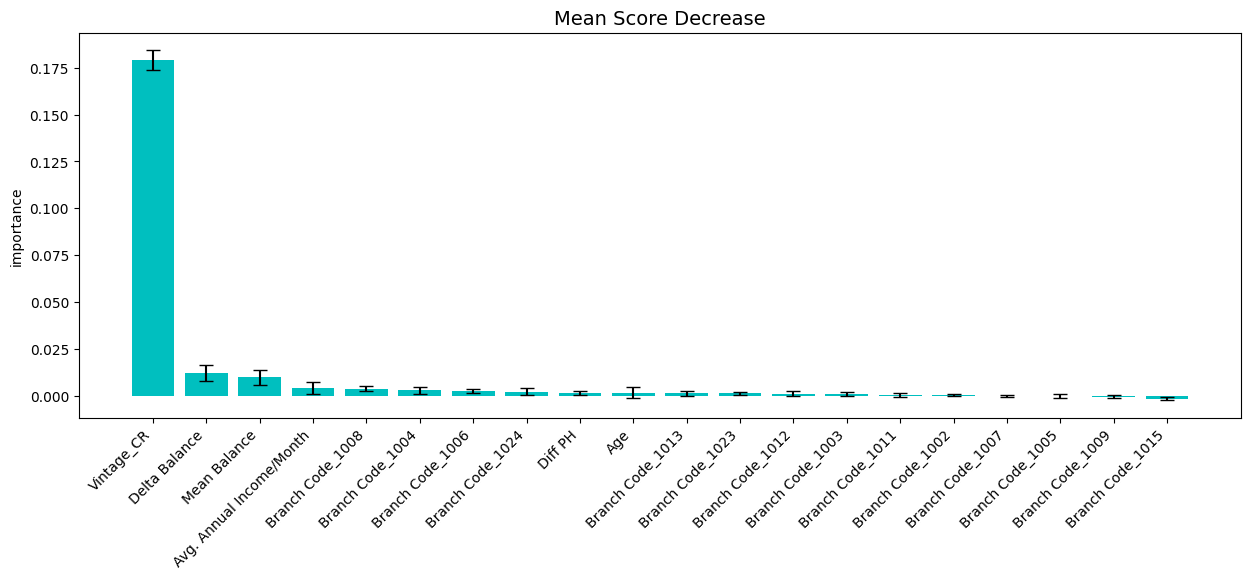

In [ ]:
from jcopml.feature_importance import mean_score_decrease
df_imp1 = mean_score_decrease(X1_train, y1_train, grid, plot= True, topk=20)

The CR_variable is considered important/very influential in determining whether or not to pay, because it is very dominant compared to other variables

### Eksperimen 2

In [ ]:
y2_pred =grid2.predict(X2_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test, y2_pred))
print("Recall:",metrics.recall_score(y2_test, y2_pred))
metrics.completeness_score

Accuracy: 0.7593653591890701
Recall: 0.40924092409240925


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [ ]:
y2_pred_val =grid2.predict(X2_val)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val, y2_pred_val))
print("Recall:",metrics.recall_score(y2_val, y2_pred_val))
metrics.completeness_score

Accuracy: 0.6356302076444915
Recall: 0.24437061646363972


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

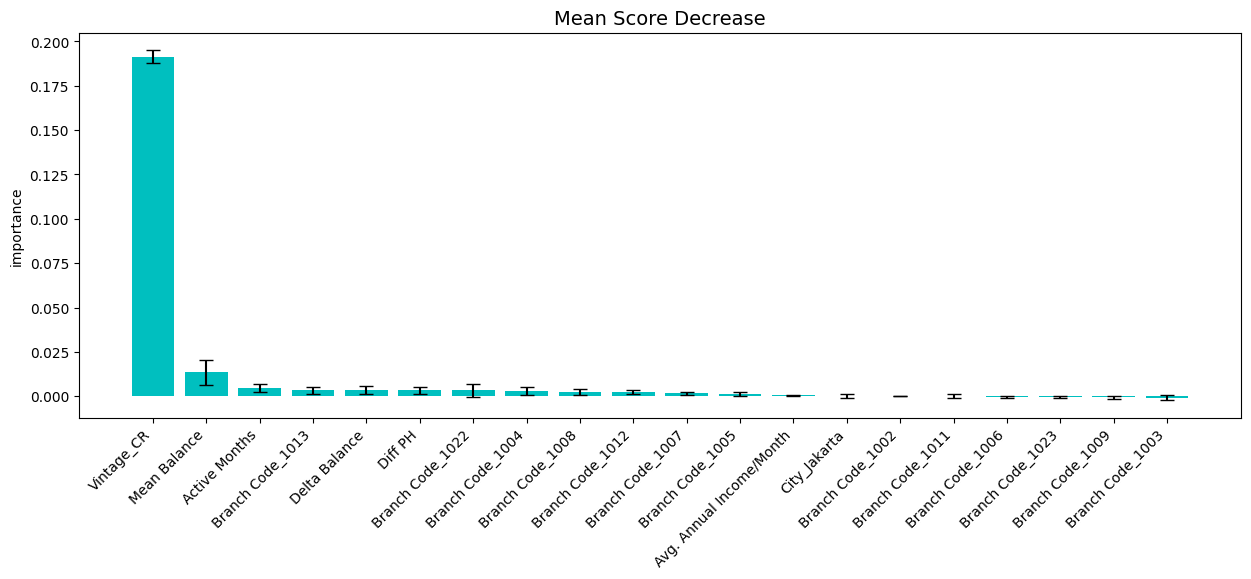

In [ ]:
df_imp2 = mean_score_decrease(X2_train, y2_train, grid2, plot= True, topk=20)

The CR_variable is considered important/very influential in determining whether or not to pay, because it is very dominant compared to other variables

## Gradient Boosting

### Eksperimen 1

In [ ]:
y11_pred =GB_Grid.predict(X1_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_test, y11_pred))
print("Recall:",metrics.recall_score(y1_test, y11_pred))
metrics.completeness_score

Accuracy: 0.6862053768179814
Recall: 0.6056105610561056


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [ ]:
y11_pred_val =GB_Grid.predict(X1_val)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val, y11_pred_val))
print("Recall:",metrics.recall_score(y1_val, y11_pred_val))
metrics.completeness_score

Accuracy: 0.5933077635233435
Recall: 0.4485049833887043


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

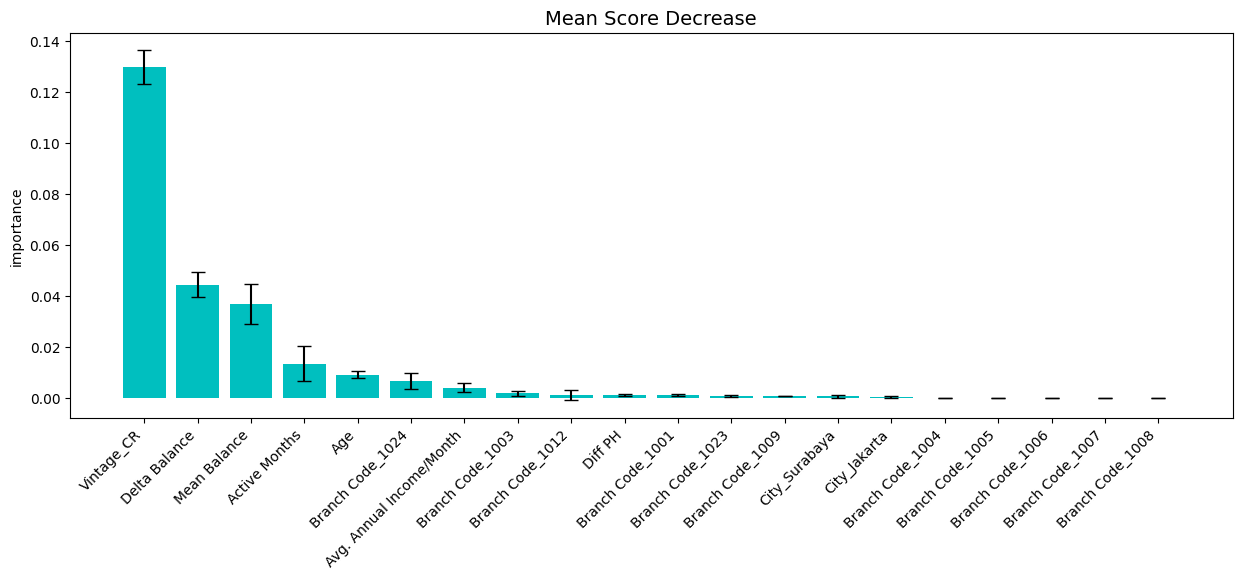

In [ ]:
df_imp3 = mean_score_decrease(X1_train, y1_train, GB_Grid, plot= True, topk=20)

### Eksperimen 2

In [ ]:
y22_pred =GB_Grid2.predict(X2_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test, y22_pred))
print("Recall:",metrics.recall_score(y2_test, y22_pred))
metrics.completeness_score

Accuracy: 0.7192595857205818
Recall: 0.5066006600660066


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [ ]:
y22_pred_val =GB_Grid2.predict(X2_val)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val, y22_pred_val))
print("Recall:",metrics.recall_score(y2_val, y22_pred_val))
metrics.completeness_score

Accuracy: 0.6306044174051052
Recall: 0.38870431893687707


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

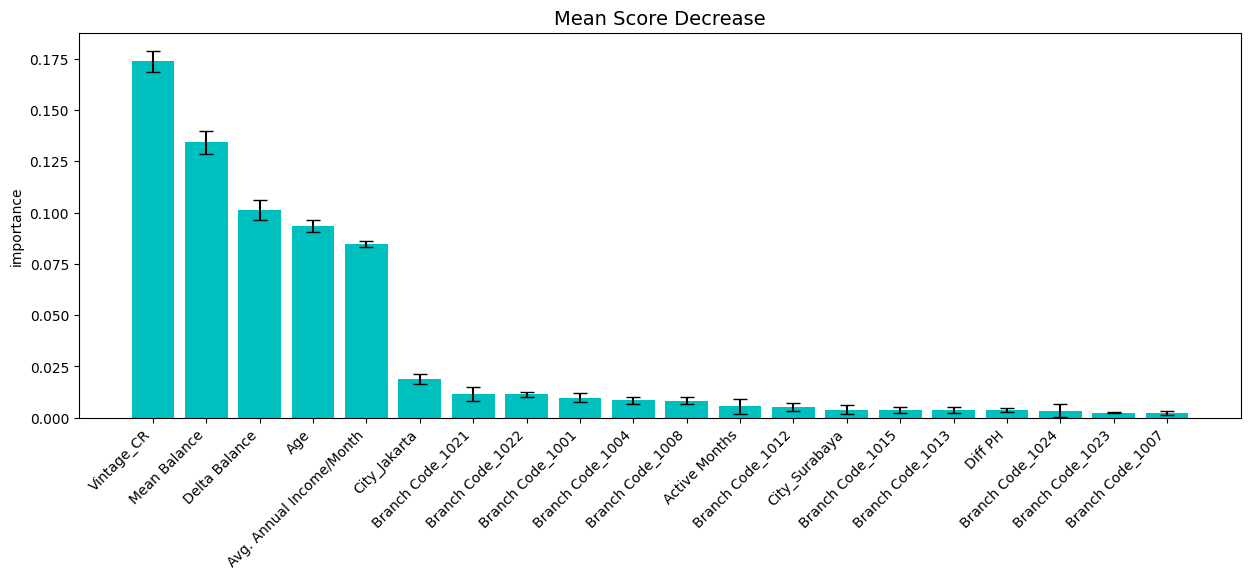

In [ ]:
df_imp4 = mean_score_decrease(X2_train, y2_train, GB_Grid2, plot= True, topk=20)

of the 5 variables have a high role in determining whether to pay or not

## Random Forest

### Eksperimen 1

In [ ]:
# mengecek akurasi dan recall data predict
y12_pred =RF_Grid.predict(X1_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_test, y12_pred))
print("Recall:",metrics.recall_score(y1_test, y12_pred))
metrics.completeness_score

Accuracy: 0.8096077567210225
Recall: 0.334983498349835


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [ ]:
# mengecek akurasi dan recall data validasi
y12_pred_val =RF_Grid.predict(X1_val)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val, y12_pred_val))
print("Recall:",metrics.recall_score(y1_val, y12_pred_val))
metrics.completeness_score

Accuracy: 0.7038751487898426
Recall: 0.35142118863049093


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

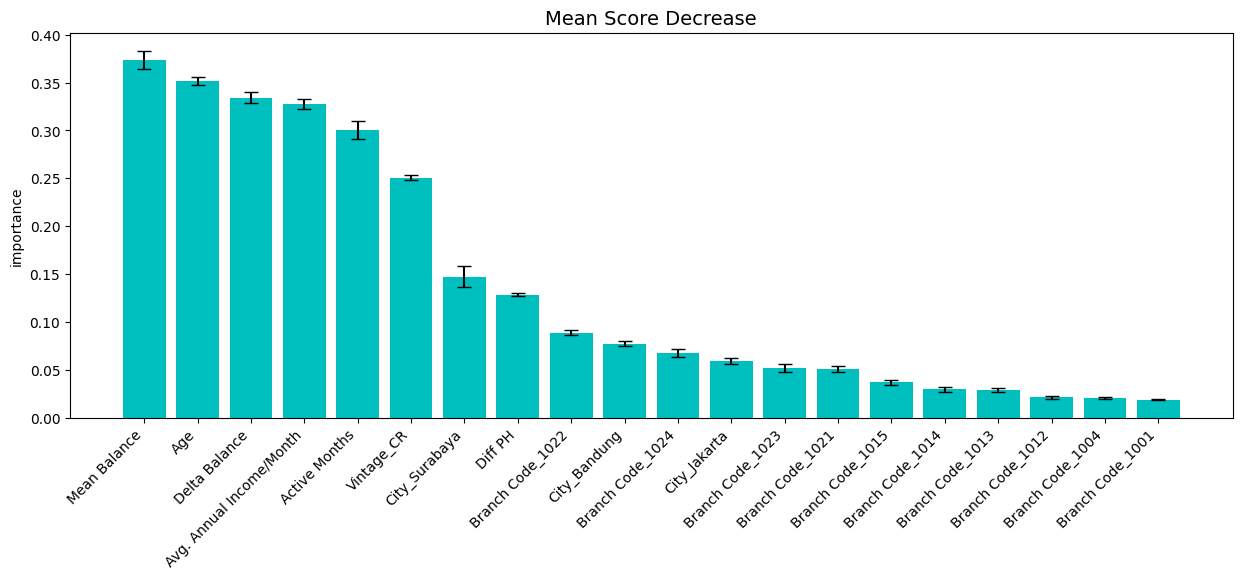

In [ ]:
df_imp5 = mean_score_decrease(X1_train, y1_train, RF_Grid, plot= True, topk=20)

### Eksperimen 2

In [ ]:
y21_pred =RF_Grid2.predict(X2_test)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test, y21_pred))
print("Recall:",metrics.recall_score(y2_test, y21_pred))
metrics.completeness_score

Accuracy: 0.8122520934332305
Recall: 0.3415841584158416


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [ ]:
y21_pred_val =RF_Grid2.predict(X2_val)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val, y21_pred_val))
print("Recall:",metrics.recall_score(y2_val, y21_pred_val))
metrics.completeness_score

Accuracy: 0.699907419653485
Recall: 0.3196751568844592


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

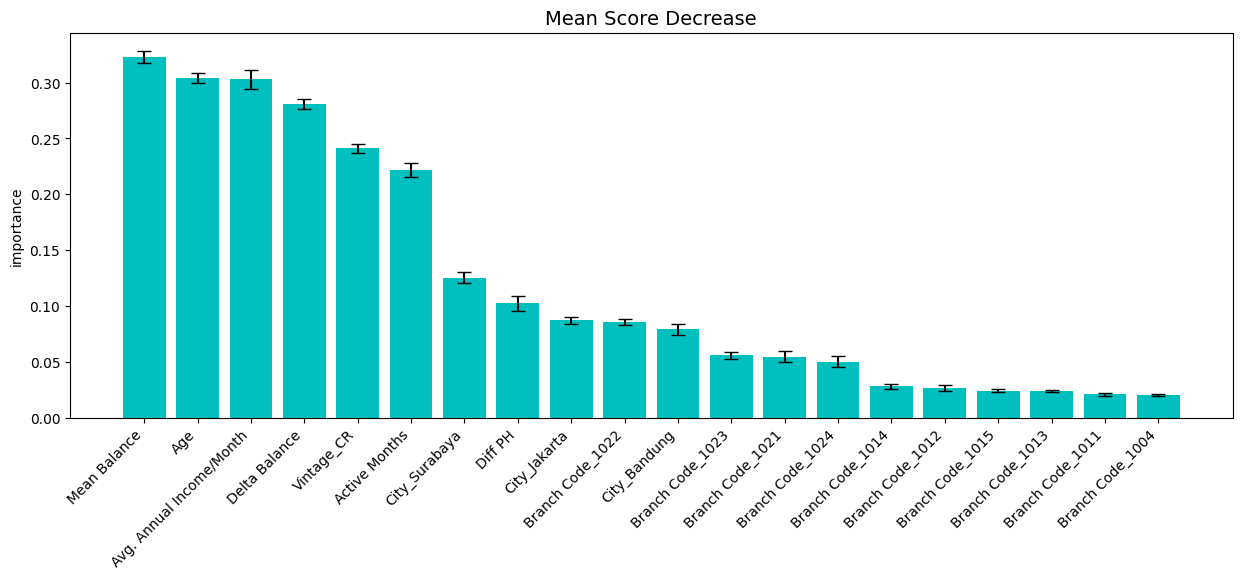

In [ ]:
df_imp6 = mean_score_decrease(X2_train, y2_train, RF_Grid2, plot= True, topk=20)

# Conclusion

Of all the models, the average accuracy is above 60% but the recall is below 40%. This means that there are still many customers who actually have the potential to default but are predicted not to default. So it can be said that in this iteration of model development, the desired objectives have not yet been achieved.

Future development solutions that can be implemented include:

1. Increasing the sample (the number of customers assuming the currently available dataset is not the total customer population)
2. Oversampling the minority class (defaulters) so that model building is not biased
3. Expanding time horizons
4. Try variations of other variables (adding new variables, or removing variables that have a low importance value in the last result)
5. Trying to expand hyperparameter combinations in model building
6. Try other supervised machine learning algorithms